# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

# Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Загрузка и подготовка данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

Загрузим и изучим данные

In [2]:
df = pd.read_csv('./datasets/users_behavior.csv')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [4]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


In [4]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

### Замена типа данных

Заменим типы данных в столбцах **calls** и **messages**

In [5]:
df = df.astype({'calls':'int', 'messages':'int'}, copy=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


### Обработка дубликатов

Посмотрим, есть ли явные дубликаты в таблице:

In [6]:
df.duplicated().sum()

0

### Посмотрим на данные на диаграмме размаха

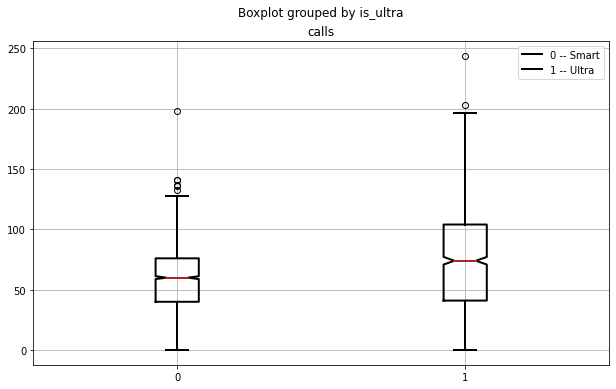

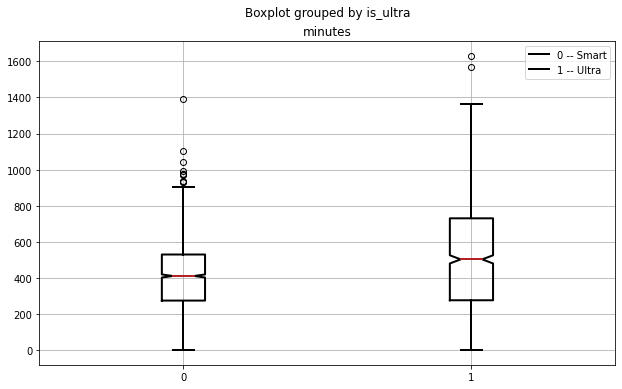

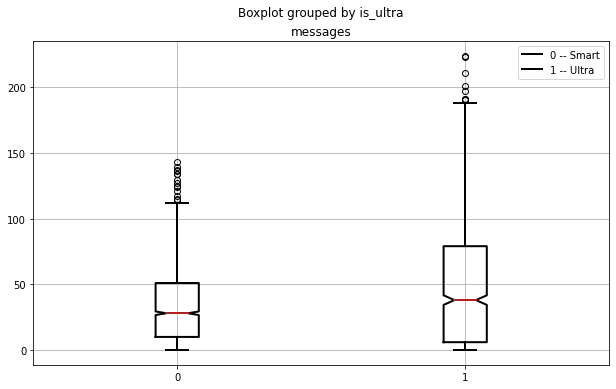

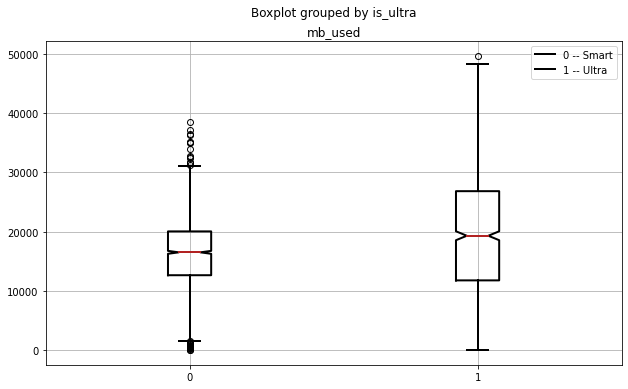

In [7]:
for row in ['calls', 'minutes', 'messages', 'mb_used']:
    ax = df.boxplot(column=row, by='is_ultra', figsize=(10,6), notch=True,
                    boxprops=dict(linestyle='-', linewidth=2),
                    medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
                    whiskerprops=dict(linestyle='-', linewidth=2),
                    capprops=dict(linestyle='-', linewidth=2))
                    #showfliers=False)
    plt.legend(['0 -- Smart','1 -- Ultra'])
    ax.set_xlabel('')
    plt.show()


### Вывод

В данных отсутствуют пропуски и дубликаты. Но как видно пользователей на тарифе “Смарт” в 2 раза больше, чем на тарифе “Ультра”, что может повлиять на дальнейшие предсказания.

## Разобьем признаки для обучения

Сохраним признаки в переменные **features** и **target**.

In [8]:
features = df.drop(columns=['is_ultra'])
target = df['is_ultra']

Разделим исходные данные на обучающую, валидационную и тестовую выборки.

In [9]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

## Обучение модели

Исследуем качество разных моделей

### Дерево решений

In [10]:
best_model_decision = None
best_result_decision = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result_decision:
        best_model_decisin = model 
        best_result_decision = result
print('Лучшая модель:', best_model_decisin)
print('Качество модели:', best_result_decision)


Лучшая модель: DecisionTreeClassifier(max_depth=3, random_state=12345)
Качество модели: 0.7853810264385692


### Случайный лес

In [11]:
best_model_random = None
best_result_random = 0
for est in range(1, 51):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result_random:
            best_model_random = model
            best_result_random = result
print('Лучшая модель:', best_model_random)
print('Качество модели:', best_result_random)

Лучшая модель: RandomForestClassifier(max_depth=8, n_estimators=40, random_state=12345)
Качество модели: 0.8087091757387247


### Логистическая регрессия

In [12]:
model_logistic = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_logistic.fit(features_train, target_train)
result_logistic = model_logistic.score(features_valid, target_valid)
print('Качество модели:', result_logistic)        

Качество модели: 0.7107309486780715


### Вывод

Из трех моделей, лучшей оказалась модель “Случайный лес”. Качество модели: 0.8087091757387247

## Тестирование

Проверим модель “Случайный лес”, на тестовой выборке.

In [13]:
result_test_random = best_model_random.score(features_test, target_test)
print('Качество модели:', result_test_random)

Качество модели: 0.7962674961119751


Проверим остальные модели 

In [14]:
result_test_decision = best_model_decisin.score(features_test, target_test)
result_test_logistic = model_logistic.score(features_test, target_test)
print('Дерево решений:', result_test_decision)
print('Логистическая регрессия:', result_test_logistic)

Дерево решений: 0.7791601866251944
Логистическая регрессия: 0.6842923794712286


**Вывод**

Был произведен анализ пользователей компании «Мегалайн», на тарифах Смарт и Ультра. Для рекомендаций тарифа, была найдена модель с наилудшими предсказаниями метрики **RandomForestClassifier(max_depth=8, n_estimators=40, random_state=12345)** с метрикой 0,79. 

## Проверка модели на адекватность

Проверим модели на вменяемость использовав DummyClassifier.

In [15]:
model_dummy = DummyClassifier(strategy='most_frequent').fit(features_train, target_train)
predictions_valid = model_dummy.predict(features_valid)

print('На валидационной выборке: ', model_dummy.score(features_valid, target_valid)) 
print('На тестовой выборке: ', model_dummy.score(features_test, target_test)) 

На валидационной выборке:  0.7060653188180405
На тестовой выборке:  0.6842923794712286


Так как наша модель предсказывает лучше, чем DummyClassifier, то она работает 